In [1]:
import sys
sys.path.append('/home/lpodgorsek/mag/scripts')

from relationGraph import Relation, RelationGraph, MatrixOfRelationGraph
from autoencoder import seedy, AutoEncoder
import utilityFunctions as uf
from main import test_build_relation_graph_with_symertic_data, test_convert_graph_to_2D_matrix, test_get_matix_for_autoencoder, test_autoencoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from base import load_source
from base2 import load_dicty, load_pharma
import utilityFunctions as uf
import autoencoder as ae
import multimodal as mm


from os.path import join
import numpy as np
import pandas as pd
import multiprocessing

from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import mean_squared_error
from fastcluster import linkage
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, Layer, Reshape, UpSampling2D, Flatten, Masking, Dropout, concatenate, Conv2D, MaxPooling2D, BatchNormalization, Lambda
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, History
from tensorflow import set_random_seed
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from tensorflow.keras.utils import multi_gpu_model

In [2]:
def select_N_cells(data, num_of_cells):
    # data = (1,1024,128,1)
    # num_of_cells = 10
    _,row,col,_ = data.shape
    data_flatten = data.flatten()
    rand_vector = np.random.choice(np.flatnonzero(data_flatten), num_of_cells, replace=False)
    removed_cells = []
    
    for i in range(len(rand_vector)):
        v = data_flatten[rand_vector[i]]
        # removed_cells = [(100,1), (223, 1), (2244, 1), ...]
        removed_cells.append((rand_vector[i], v))
    return removed_cells

def save_test_cells(filename, data):
    f = uf.my_savez(filename)
    f.savez(data)
    f.close()
    
    
def load_test_cells(filename):
    f = np.load(filename)
    data = f[f.files[0]]
    new_data = []
    for line in data:
        new_data.append((int(line[0]), line[1]))
        
    return new_data


def remove_cells_from_data(data, list_of_cells):
    # data = (1,1024,128,1)
    # list_of_cells = [(111, 1.0), (2244, 0.34), ...]
    _,row,col,_ = data.shape
    data_flatten = data.flatten()
    for index, _ in list_of_cells:
        data_flatten[int(index)] = 0
        
    return data.reshape(1, row, col, 1)
        
    
    

def data_generator(filenames, org_data, batch_size=1, testing_cells=None, removed_cells=False):
    # n_pack => 1 samples of matrix
    # n_pack = batch_size
    # org_data = [[1,1024,128,1], [1,1024,256,1], [1,1024,1024,1]]
    # testing_cells = [[(111, 1.0), (2244, 0.34), ...], [(111, 1.0), (2244, 0.34), ...], ...]
    
    files = []              # different files
    num_packs = []          # subpacked inside of file
    for filename in filenames:
        f = np.load(filename)
        files.append(f)  
        num_packs.append(f.files)
    
    counter = 0
    while True:
        x = []
        y = []
        for i in range(len(files)):
            _x = []
            _y = []
            for j in range(batch_size):
                rand_num = np.random.randint(len(num_packs[i]))
                f = files[i]
                pack = num_packs[i]
                data = f[pack[rand_num]] 
                
                if testing_cells is not None and removed_cells:
                    data = remove_cells_from_data(data, testing_cells[i])

                _, row, col, _ = data.shape
                if col != 1021:
                    _x.append(f[pack[rand_num]])
                    _y.append(org_data[i])
            
            _x = np.asarray(_x)
            _y = np.asarray(_y)

            _x = _x[:, 0, :, :, :]
            _y = _y[:, 0, :, :, :]
        
            x.append(_x)
            y.append(_y)
            
        yield (x, y)
        
            
def top_N_rows(data, rows=100):
    _, row, col, _ = data.shape
    rows = row
    remove_col = col % 6
    data = data.reshape(row, col)
    new_data = data[:rows, :(col - remove_col)]
    return new_data.reshape(1, rows, col - remove_col, 1)
    
    
def shuffle_data(org_data):
    shufle_data = []
    for data in org_data:
        tmp_data = data
        _, row, col, _ = tmp_data.shape
        tmp_data = tmp_data.flatten()
        np.random.shuffle(tmp_data)  # shuffle org data
        shufle_data.append(np.array(tmp_data).reshape(1, row, col, 1))

    return shufle_data


def replace_and_shuffle_data_with_random(org_data):
    shufle_data = []
    for data in org_data:
        tmp_data = data
        _, row, col, _ = tmp_data.shape
        tmp_data = tmp_data.flatten()
        tmp_data[tmp_data > 0] = 1;   # set nonzero values to 1
        tmp_data = tmp_data * np.random.rand(len(tmp_data))  # multiply with random vecotor
        shufle_data.append(np.array(tmp_data).reshape(1, row, col, 1))

    return shufle_data

    
def order_inputs(model, org_data):
    new_order_data = []
    for inp in model.inputs:
        _, x, y, _ = inp.shape
        for data in org_data:
            _, row, col, _ = data.shape
            if x == row and y == col:
                new_order_data.append(np.array(data).reshape(1,row,col,1))
                break

    return new_order_data


def duplicateBatchData(data, batch=2):
    new_data = []
    for i in range(len(data)):
        b = []
        for j in range(batch):
            b.append(data[i])

        b = np.asarray(b)
        b = b[:,0,:,:,:]

        new_data.append(b)
        
    return new_data;

    
class MultiModal:
    
    def __init__(self, graph=None, path='', num_of_test_cells=10, load_test_cells=False):
        self.input_visibles = []
        self.input_layers = []
        self.outputs_layers = []
        self.input_data_size = []
        self.filenames = []
        self.inputs = None
        self.model = None
        self.path = path
        self.folder = path
        self.graph = graph
        self.org_data = []
        self.predict_data = []
        self.base_line = []
        self.shuffled_data = []
        self.dropout = 0.5
        self.num_of_saved_cells = num_of_test_cells
        self.saved_cells_for_test = []
        self.predict_saved_cells_for_test = []
        self.is_first_iteration = True
        self.fake_org_data = []
        self.activation = 'relu'
        self.load_test_cells = load_test_cells
        
        if graph is not None:
            self._read_graph(graph)
        self._callbacks()
        
        for i in range(len(self.org_data)):
            self.fake_org_data.append(remove_cells_from_data(self.org_data[i], self.saved_cells_for_test[i]))
                    
    def _read_graph(self, graph):
        already = set()
        for obj in graph.objects.values():        
            for relation in obj.relation_x:
                if relation.name not in already:
                    self._set_params(relation)
                    already.add(relation.name)

            for relation in obj.relation_y:
                if relation.name not in already:
                    self._set_params(relation)
                    already.add(relation.name)
                    
    def set_path_to_files(self, path):
        self.path = path
        self.filenames = []
        already = set()
        for obj in self.graph.objects.values():        
            for relation in obj.relation_x:
                if relation.name not in already:
                    self.filenames.append(self.path + relation.name + '.npz')
                    already.add(relation.name)

            for relation in obj.relation_y:
                if relation.name not in already:
                    self.filenames.append(self.path + relation.name + '.npz')
                    already.add(relation.name)
                    
    def set_path_to_folder(self, folder):
        self.folder = folder
                        
    def _set_params(self, relation):
        print(relation.name + '\t' + str(relation.matrix.shape))
        
        row, col = relation.matrix.shape
        
        data = np.array(relation.matrix).reshape(1,row,col,1)
#         new_data = top_N_rows(data)
        new_data = data
        _, new_r, new_c, _ = new_data.shape
        self.org_data.append(new_data)
        if self.load_test_cells == True:
            test_cells = load_test_cells(self.folder + 'samples_' + relation.name + '.npz')
            self.saved_cells_for_test.append(test_cells)
            self.num_of_saved_cells = len(test_cells)
        else:
            test_cells = select_N_cells(new_data, self.num_of_saved_cells)
            self.saved_cells_for_test.append(test_cells)
            save_test_cells(self.folder + 'samples_' + relation.name, test_cells)
        self.input_data_size.append((new_r, new_c))
        self._input_layer((new_r, new_c))
        self.filenames.append(self.path + relation.name + '.npz')
        
    def _input_layer(self, input_size):
        row, col = input_size
        visible = Input(shape=(row, col, 1))
#         Conv2D filtered by columns
        
        layer = Conv2D(128, (3, 3), activation=self.activation, padding='same')(visible)
#         layer = Conv2D(128, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        layer = Conv2D(64, (3, 3), activation=self.activation, padding='same')(layer)
#         layer = Conv2D(64, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        layer = Conv2D(32, (3, 3), activation=self.activation, padding='same')(layer)
#         layer = Conv2D(32, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        layer = Conv2D(16, (3, 3), activation=self.activation, padding='same')(layer)
#         layer = Conv2D(16, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        if col == 1024:
            layer = Conv2D(8, (3, 3), activation=self.activation, padding='same')(layer)
#             layer = Conv2D(8, (3, 3), activation='relu', padding='same')(layer)
#             layer = MaxPooling2D((2, 2), padding='same')(layer)
            
        layer = Flatten()(layer)
        layer = Dense(1024, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(512, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(256, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(128, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(64, activation=self.activation)(layer)
        
        self.input_layers.append(layer)
        self.input_visibles.append(visible)
    
    def _output_layer(self, input_size):
        row, col = input_size
        layer = None
        
        if col == 128:
            layer = Reshape((64, 8, 2))(self.inputs)
        elif col == 256:
            layer = Reshape((64, 16, 1))(self.inputs)
        elif col == 1024:
            layer = Reshape((32, 32, 1))(self.inputs)
            layer = Conv2D(8, (3, 3), activation=self.activation, padding='same')(layer)
            layer = UpSampling2D((2, 2))(layer)
        
        layer = Conv2D(16, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(32, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(64, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(128, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(layer)

        self.outputs_layers.append(layer)
        
    def _decoder(self):
        layer = Dense(128, activation=self.activation)(self.inputs)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(256, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(512, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(1024, activation=self.activation)(layer) 
        self.inputs = layer
        
    def _callbacks(self):
        log_dir = '/home/lpodgorsek/data/logs/'
        self.callbacks = [
            TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=True)
#             EarlyStopping(monitor='loss', min_delta=0, patience=3, verbose=0, mode='auto'),
            
        ]
        
    def build_model(self, optimizer='sgd', loss='mse', metrics=['mae', 'acc'], gpu=1):
        self.inputs = concatenate(self.input_layers)
        self.inputs = Dense(64, activation=self.activation)(self.inputs) 
#         layer = concatenate(self.input_layers)
#         layer = Dense(512, activation=self.activation)(layer)
#         layer = Dropout(self.dropout)(layer)
#         layer = Dense(256, activation=self.activation)(layer)
#         layer = Dropout(self.dropout)(layer)
#         layer = Dense(128, activation=self.activation)(layer)
#         layer = Dropout(self.dropout)(layer)
#         layer = Dense(64, activation=self.activation)(layer)
#         self.inputs = layer
        self._decoder()

        [self._output_layer(data_size) for data_size in self.input_data_size]
        
        self.model = Model(inputs=self.input_visibles, outputs=self.outputs_layers)
        
        try:
            with tf.device('/cpu:0'):
                self.model = multi_gpu_model(self.model, gpus=gpu, cpu_merge=True, cpu_relocation=True)
        except e:
            print(e)
            pass
        
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        self.model.summary()
        
    def fit(self, batch_size, epochs):
        self.batch_size = batch_size;
        self.model.fit_generator(
            data_generator(self.filenames, self.fake_org_data, batch_size, self.saved_cells_for_test, self.is_first_iteration), 
            steps_per_epoch=batch_size, 
            epochs=epochs,
            callbacks=self.callbacks
        )
        self.is_first_iteration = False
        
    def save(self, path, version):
        self.model.save(path + 'experiment_' + version + '.h5')

    def load_model(self, path, version):
        self.model = load_model(path + 'experiment_' + version + '.h5')
        
    def predict_hidden_cells(self):
        list_of_predict = {}
            
        print()
        print("Predict Original Diff \t\tPredict Original Diff \t\tPredict Original Diff")
        print("---------------------------------------------------------------------------------------")
        avg_diff = np.zeros(len(self.saved_cells_for_test))
        for i in range(len(self.saved_cells_for_test[0])):
            for j in range(len(self.saved_cells_for_test)):
                idx, val = self.saved_cells_for_test[j][i]
                predict_val = self.predict_data[j].flatten()[idx]
                diff_abs = np.abs(self.predict_data[j].flatten()[idx] - val)
                avg_diff[j] += diff_abs
                
                if j not in list_of_predict:
                    list_of_predict[j] = [(idx, predict_val)] 
                else:
                    list_of_predict[j].append((idx, predict_val)) 
                print(str(self.saved_cells_for_test[j][i]) + ' ' + format(predict_val, '.5f') + ' ' + format(val, '.5f') + ' ' + format(diff_abs, '.5f'), end=" \t")
            print()
        print("---------------------------------------------------------------------------------------")

        for i in range(len(avg_diff)):
            val = avg_diff[i]*100/len(self.saved_cells_for_test[0])
            print("\t\t" + format(val, '.5f') + "%", end="\t")
        print()
        
        for i in range(len(list_of_predict)):
            self.predict_saved_cells_for_test.append(list_of_predict[i])
        
    def predict_generator(self, batch_size=10, iteration=1):
        predict = self.model.predict_generator(
            data_generator(self.filenames, self.fake_org_data, batch_size),
            steps=100
        )

        for i in range(len(self.org_data)):
            _,row, col,_ = predict[i].shape
            print(predict[i].shape)
            mse = 0
            for j in range(predict[i].shape[0]):
                mse += mean_squared_error(self.org_data[i].flatten(), predict[i][j].flatten())

            print('MSE' + str(i+1) + ': ' + format(mse*100/predict[i].shape[0], '.5f'))
            print()

            if col == 128:
                filename = self.folder + 'predict_' + str(iteration) + '_ann.npz'
            elif col == 256:
                filename = self.folder + 'predict_' + str(iteration) + '_expr.npz'
            elif col == 1024:
                filename = self.folder + 'predict_' + str(iteration) + '_ppi.npz'
            else:
                raise ValueError("ERROR: wrong data!!")
                
            f = uf.my_savez(filename)

            for j in range(predict[i].shape[0]):
                data = predict[i][j].reshape(1, row, col, 1)
                f.savez(data)
            f.close()
        
    def predict(self, random=False):
        self.org_data = order_inputs(self.model, self.org_data)
            
        if random == True:
            self.shuffled_data = replace_and_shuffle_data_with_random(self.org_data)
        else: 
            self.shuffled_data = shuffle_data(self.org_data)
            
        self.predict_data = self.model.predict(self.org_data)
        self.base_line = self.model.predict(self.shuffled_data)
        outputHeader = 'Data\t\t'
        outputHeader += 'Density\t\t'
        outputHeader += 'Predict\t\t'
        outputHeader += 'BaseLine\t'
        outputHeader += 'AVG Mean\t'
        outputHeader += 'Predict (mean)\t'
        outputHeader += 'Predict (min)\t'
        outputHeader += 'Predict (max)\t'
        print(outputHeader)
        
#         print('Data \t\t\tDensity \tPredict \tBaseLine \tAVG Mean')
        for i in range(len(self.org_data)):
            _, row, col, _ = self.org_data[i].shape 
            mse = mean_squared_error(self.org_data[i].flatten(), self.predict_data[i].flatten())
            mse_base_line = mean_squared_error(self.shuffled_data[i].flatten(), self.base_line[i].flatten())
            
            non_zeros = self.org_data[i].flatten()
            non_zeros[self.org_data[i].flatten() > 0] = 1
            org_mean = round(np.mean(non_zeros * self.org_data[i].flatten()), 5)
            predict_mean = round(np.mean(non_zeros * self.predict_data[i].flatten()), 5)
            
            outputBody = '(' + str(row) + ',' + str(col) + ') ' + '\t'
            outputBody += str(round((np.count_nonzero(self.org_data[i])/(row * col)) * 100, 2)) + '% \t\t'
            outputBody += str(round(mse * 100, 5)) + '% \t'
            outputBody += str(round(mse_base_line * 100, 5)) + '% '+ '\t'
            outputBody += str(org_mean) + '\t\t'
            outputBody += str(predict_mean) + '\t\t'
            outputBody += str(round(min(self.predict_data[i].flatten()), 5)) + '\t\t'
            outputBody += str(round(max(self.predict_data[i].flatten()), 5)) + '\t'
            print(outputBody)
            
    def predictMultiGPU(self, random=False, gpu=1):
        self.org_data = order_inputs(self.model, self.org_data)
            
        if random == True:
            self.shuffled_data = replace_and_shuffle_data_with_random(self.org_data)
        else: 
            self.shuffled_data = shuffle_data(self.org_data)
            
        outputHeader = 'Data\t\t'
        outputHeader += 'Density\t\t'
        outputHeader += 'Predict\t\t'
        outputHeader += 'BaseLine\t'
        outputHeader += 'AVG Mean\t'
        outputHeader += 'Predict (mean)\t'
        outputHeader += 'Predict (min)\t'
        outputHeader += 'Predict (max)\t'
        print(outputHeader)
        
        if gpu == 1:
            self.predict_data = self.model.predict(self.org_data)
            self.base_line = self.model.predict(self.shuffled_data)

    #         print('Data \t\t\tDensity \tPredict \tBaseLine \tAVG Mean')
            for i in range(len(self.org_data)):
                _, row, col, _ = self.org_data[i].shape 
                mse = mean_squared_error(self.org_data[i].flatten(), self.predict_data[i].flatten())
                mse_base_line = mean_squared_error(self.shuffled_data[i].flatten(), self.base_line[i].flatten())

                non_zeros = self.org_data[i].flatten()
                non_zeros[self.org_data[i].flatten() > 0] = 1
                org_mean = round(np.mean(non_zeros * self.org_data[i].flatten()), 5)
                predict_mean = round(np.mean(non_zeros * self.predict_data[i].flatten()), 5)

                outputBody = '(' + str(row) + ',' + str(col) + ') ' + '\t'
                outputBody += str(round((np.count_nonzero(self.org_data[i])/(row * col)) * 100, 2)) + '% \t\t'
                outputBody += str(round(mse * 100, 5)) + '% \t'
                outputBody += str(round(mse_base_line * 100, 5)) + '% '+ '\t'
                outputBody += str(org_mean) + '\t\t'
                outputBody += str(predict_mean) + '\t\t'
                outputBody += str(round(min(self.predict_data[i].flatten()), 5)) + '\t\t'
                outputBody += str(round(max(self.predict_data[i].flatten()), 5)) + '\t'
                print(outputBody)
                
        else:            
            self.predict_data = self.model.predict(duplicateBatchData(self.org_data, gpu))
            self.base_line = self.model.predict(duplicateBatchData(self.shuffled_data, gpu))
            
    #         print('Data \t\t\tDensity \tPredict \tBaseLine \tAVG Mean')
            for i in range(len(self.org_data)):
                _, row, col, _ = self.org_data[i].shape 
                mse = mean_squared_error(self.org_data[i][0].flatten(), self.predict_data[i][0].flatten())
                mse_base_line = mean_squared_error(self.shuffled_data[i][0].flatten(), self.base_line[i][0].flatten())

                non_zeros = self.org_data[i][0].flatten()
                non_zeros[self.org_data[i][0].flatten() > 0] = 1
                org_mean = round(np.mean(non_zeros * self.org_data[i][0].flatten()), 5)
                predict_mean = round(np.mean(non_zeros * self.predict_data[i][0].flatten()), 5)

                outputBody = '(' + str(row) + ',' + str(col) + ') ' + '\t'
                outputBody += str(round((np.count_nonzero(self.org_data[i][0])/(row * col)) * 100, 2)) + '% \t\t'
                outputBody += str(round(mse * 100, 5)) + '% \t'
                outputBody += str(round(mse_base_line * 100, 5)) + '% '+ '\t'
                outputBody += str(org_mean) + '\t\t'
                outputBody += str(predict_mean) + '\t\t'
                outputBody += str(round(min(self.predict_data[i][0].flatten()), 5)) + '\t\t'
                outputBody += str(round(max(self.predict_data[i][0].flatten()), 5)) + '\t'
                print(outputBody)

In [3]:
numOfExperiment = 'model_weigth'
epchos = 5
GPU = 3
batch_size = 3 * GPU
# path_data = '/data/samples/multiple_inputs_clustering/dicty/'
folder = '/home/lpodgorsek/data/cnn/dicty/_00/'
#     folder = '/home/lpodgorsek/data/cnn/dicty/_05/'
#     folder = '/home/lpodgorsek/data/cnn/dicty/_10/'
#     folder = '/home/lpodgorsek/data/cnn/dicty/_25/'
#     folder = '/home/lpodgorsek/data/cnn/dicty/_50/'
graph1 = load_dicty('clustering', 2)

model = MultiModal(graph=graph1, path=folder, num_of_test_cells=100, load_test_cells=False)
#     model.build_model(optimizer='sgd', loss='mse')
#     loss='binary_crossentropy'
model.build_model(optimizer='adadelta', loss='binary_crossentropy', metrics=['mae', 'acc'], gpu=GPU)
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment) + '_1')
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()
model.predict_generator(batch_size, 1)

model.set_path_to_files(folder + 'predict_1_')
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment) + '_2')
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()
model.predict_generator(batch_size, 2)

model.set_path_to_files(folder + 'predict_2_')
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment) + '_3')
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()
model.predict_generator(batch_size, 3)

model.set_path_to_files(folder + 'predict_3_')
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment))
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()

In [3]:
if 'model' in locals():
    del model
    
numOfExperiment = 'model_weigth'
graph1 = load_dicty('clustering', 2)
folder = '/home/lpodgorsek/data/cnn/dicty/_00/'

model = MultiModal(graph=graph1, path=folder, load_test_cells=True)
model.load_model(folder, str(numOfExperiment))
model.predictMultiGPU(random=False, gpu=3)

0.0
1.0

0.0
1.0

0.0
1.0
-------------RelationGraph-------------
Gene	1024
3	ann-(1024, 128), expr-(1024, 256), ppi-(1024, 1024)
0	
GO term	128
0	
1	ann-(1024, 128)
Experimental condition	256
0	
1	expr-(1024, 256)

ann	(1024, 128)
expr	(1024, 256)
ppi	(1024, 1024)
Data		Density		Predict		BaseLine	AVG Mean	Predict (mean)	Predict (min)	Predict (max)	
(1024,128) 	4.89% 		0.249% 	8.9232% 	0.04888		0.04563		0.0		1.0	
(1024,256) 	95.4% 		0.49086% 	6.42226% 	0.82382		0.83287		0.0		0.98881	
(1024,1024) 	3.04% 		1.88876% 	2.25392% 	0.02452		0.00286		0.0		0.56883	


In [4]:
model.predict_hidden_cells()


Predict Original Diff 		Predict Original Diff 		Predict Original Diff
---------------------------------------------------------------------------------------
(25214, 1.0) 1.00000 1.00000 0.00000 	(213910, 0.9037879560274013) 0.91948 0.90379 0.01569 	(688427, 0.938751472320377) 0.00671 0.93875 0.93204 	
(32635, 1.0) 1.00000 1.00000 0.00000 	(212974, 0.8941978001127759) 0.89727 0.89420 0.00308 	(4240, 0.9623085983510011) 0.23896 0.96231 0.72334 	
(2436, 1.0) 0.98725 1.00000 0.01275 	(44828, 0.8401417658060423) 0.86901 0.84014 0.02886 	(694929, 0.9799764428739693) 0.00619 0.97998 0.97378 	
(55808, 1.0) 0.84739 1.00000 0.15261 	(232148, 0.8783613613364569) 0.88942 0.87836 0.01106 	(600540, 0.5747938751472321) 0.01367 0.57479 0.56112 	
(44159, 1.0) 0.99912 1.00000 0.00088 	(106790, 0.8420843224691953) 0.85826 0.84208 0.01618 	(226406, 0.8680800942285042) 0.07654 0.86808 0.79154 	
(25344, 1.0) 1.00000 1.00000 0.00000 	(155900, 0.8219974944514251) 0.86602 0.82200 0.04402 	(122896, 0.99528857

(75907, 1.0) 1.00000 1.00000 0.00000 	(128738, 0.8907939275311966) 0.86659 0.89079 0.02420 	(478600, 0.9528857479387515) 0.04309 0.95289 0.90979 	
(49659, 1.0) 1.00000 1.00000 0.00000 	(45049, 0.8941921952489368) 0.86489 0.89419 0.02931 	(1053, 0.7997644287396938) 0.23269 0.79976 0.56708 	
(1921, 1.0) 0.48993 1.00000 0.51007 	(19331, 0.7751304321123971) 0.82142 0.77513 0.04629 	(69727, 0.9187279151943463) 0.15951 0.91873 0.75922 	
(83203, 1.0) 1.00000 1.00000 0.00000 	(137038, 0.9067975246968422) 0.87001 0.90680 0.03678 	(134243, 0.9599528857479388) 0.15719 0.95995 0.80276 	
(1412, 1.0) 0.42750 1.00000 0.57250 	(230832, 0.8657114302948561) 0.87980 0.86571 0.01409 	(168119, 0.4369846878680802) 0.05578 0.43698 0.38121 	
(69505, 1.0) 0.64626 1.00000 0.35374 	(131760, 0.8853994675194621) 0.87631 0.88540 0.00909 	(26889, 0.833922261484099) 0.11935 0.83392 0.71457 	
(59523, 1.0) 0.98664 1.00000 0.01336 	(129155, 0.7999979872765527) 0.85895 0.80000 0.05895 	(183631, 0.06478209658421678) 0.060

(32129, 1.0) 1.00000 1.00000 0.00000 	(95379, 0.8739483304768518) 0.87405 0.87395 0.00011 	(578870, 0.795053003533569) 0.04601 0.79505 0.74904 	
(88706, 1.0) 1.00000 1.00000 0.00000 	(241612, 0.8768043755984459) 0.88887 0.87680 0.01207 	(79093, 0.8881036513545347) 0.06915 0.88810 0.81895 	
(7579, 1.0) 0.99998 1.00000 0.00002 	(25242, 0.7675573019314136) 0.85322 0.76756 0.08567 	(484601, 0.568904593639576) 0.01683 0.56890 0.55207 	
(46591, 1.0) 1.00000 1.00000 0.00000 	(75072, 0.8197714824987464) 0.87179 0.81977 0.05202 	(593006, 0.9988221436984688) 0.02826 0.99882 0.97057 	
(69510, 1.0) 0.99254 1.00000 0.00746 	(201969, 0.8519213326274235) 0.86524 0.85192 0.01332 	(214035, 0.795053003533569) 0.11848 0.79505 0.67658 	
(104576, 1.0) 1.00000 1.00000 0.00000 	(144387, 0.8451563176955528) 0.88536 0.84516 0.04021 	(18502, 0.9116607773851589) 0.23712 0.91166 0.67454 	
(97664, 1.0) 0.99943 1.00000 0.00057 	(252561, 0.9032751260514961) 0.90218 0.90328 0.00110 	(196927, 1.0) 0.04895 1.00000 0.95

(6538, 1.0) 0.97524 1.00000 0.02476 	(22814, 0.8825255394190613) 0.88264 0.88253 0.00011 	(755803, 0.9293286219081272) 0.00588 0.92933 0.92345 	
(5898, 1.0) 0.80541 1.00000 0.19459 	(139660, 0.9163537121668187) 0.88262 0.91635 0.03374 	(727081, 0.11778563015312142) 0.01929 0.11779 0.09849 	
(22524, 1.0) 1.00000 1.00000 0.00000 	(70870, 0.9194061700759756) 0.88639 0.91941 0.03301 	(385181, 0.9976442873969376) 0.04153 0.99764 0.95612 	
(15386, 1.0) 0.76927 1.00000 0.23073 	(113532, 0.9668285208641165) 0.97460 0.96683 0.00777 	(86570, 0.9458186101295644) 0.40561 0.94582 0.54021 	
(18839, 1.0) 1.00000 1.00000 0.00000 	(249210, 0.8965609206348729) 0.91052 0.89656 0.01396 	(181253, 0.8386336866902238) 0.24783 0.83863 0.59080 	
(255, 1.0) 0.85291 1.00000 0.14709 	(125063, 0.8429265234473932) 0.86283 0.84293 0.01991 	(456738, 1.0) 0.06880 1.00000 0.93120 	
(81539, 1.0) 1.00000 1.00000 0.00000 	(46827, 0.7822246649031691) 0.82144 0.78222 0.03922 	(730112, 0.9375736160188458) 0.05051 0.93757 0.8

(14723, 1.0) 1.00000 1.00000 0.00000 	(129732, 0.8275384862003997) 0.86381 0.82754 0.03627 	(290130, 0.9658421672555949) 0.04263 0.96584 0.92322 	
(37286, 1.0) 0.91249 1.00000 0.08751 	(235146, 0.8824844958225445) 0.88283 0.88248 0.00034 	(207115, 0.8197879858657243) 0.06294 0.81979 0.75685 	
(11911, 1.0) 0.99786 1.00000 0.00214 	(99768, 0.8786554439984081) 0.87319 0.87866 0.00547 	(90549, 0.9163722025912839) 0.06410 0.91637 0.85227 	
(52095, 1.0) 1.00000 1.00000 0.00000 	(91776, 0.8377698120976199) 0.88880 0.83777 0.05103 	(653497, 0.5641931684334512) 0.02022 0.56419 0.54397 	
(23685, 1.0) 0.86867 1.00000 0.13133 	(78557, 0.8519011433995809) 0.86534 0.85190 0.01344 	(443603, 0.8433451118963486) 0.03270 0.84335 0.81064 	
(1294, 1.0) 0.46144 1.00000 0.53856 	(37519, 0.8693803242647059) 0.87489 0.86938 0.00551 	(16548, 0.9988221436984688) 0.24431 0.99882 0.75451 	
(30090, 1.0) 1.00000 1.00000 0.00000 	(144338, 0.8204261732885019) 0.86146 0.82043 0.04103 	(150773, 0.7879858657243817) 0.08

(8336, 1.0) 1.00000 1.00000 0.00000 	(231993, 0.874308461582243) 0.87402 0.87431 0.00029 	(122955, 0.9988221436984688) 0.15951 0.99882 0.83931 	
(39058, 1.0) 0.85380 1.00000 0.14620 	(148469, 0.9136190994914765) 0.90963 0.91362 0.00399 	(274436, 0.9034157832744406) 0.17744 0.90342 0.72597 	
(45583, 1.0) 0.99816 1.00000 0.00184 	(190089, 0.8901070993933204) 0.87878 0.89011 0.01132 	(532676, 0.8386336866902238) 0.03776 0.83863 0.80088 	
(12301, 1.0) 0.96558 1.00000 0.03442 	(178623, 0.8724989422770408) 0.88713 0.87250 0.01463 	(200260, 0.7267373380447586) 0.02548 0.72674 0.70126 	
(46722, 1.0) 0.99998 1.00000 0.00002 	(223926, 0.8800231017624847) 0.89559 0.88002 0.01557 	(332812, 0.9988221436984688) 0.15322 0.99882 0.84560 	
(42056, 1.0) 0.99011 1.00000 0.00989 	(114103, 0.9408533716660923) 0.97179 0.94085 0.03094 	(303203, 0.7844522968197879) 0.05238 0.78445 0.73207 	
(13563, 1.0) 0.99989 1.00000 0.00011 	(22905, 0.8969083594940086) 0.84474 0.89691 0.05217 	(187623, 0.8987043580683157) 

(9855, 1.0) 0.99992 1.00000 0.00008 	(123787, 0.8442056790026061) 0.87918 0.84421 0.03497 	(522442, 0.9340400471142521) 0.05269 0.93404 0.88135 	
(38142, 1.0) 1.00000 1.00000 0.00000 	(242387, 0.8730593950976218) 0.88975 0.87306 0.01669 	(565325, 0.9458186101295644) 0.35740 0.94582 0.58842 	
(8957, 1.0) 1.00000 1.00000 0.00000 	(105274, 0.9515216253790182) 0.87978 0.95152 0.07174 	(107091, 0.7314487632508835) 0.02024 0.73145 0.71121 	
(81026, 1.0) 1.00000 1.00000 0.00000 	(44919, 0.9098960912587629) 0.87218 0.90990 0.03772 	(735517, 0.955241460541814) 0.00778 0.95524 0.94746 	
(32255, 1.0) 1.00000 1.00000 0.00000 	(43113, 0.9763637370973544) 0.88561 0.97636 0.09075 	(2189, 0.9893992932862191) 0.22344 0.98940 0.76596 	
(35713, 1.0) 0.99270 1.00000 0.00730 	(151551, 0.8292277679913906) 0.84735 0.82923 0.01812 	(23, 0.12014134275618375) 0.28450 0.12014 0.16435 	
(4884, 1.0) 0.98268 1.00000 0.01732 	(253601, 0.8906563534851561) 0.90114 0.89066 0.01048 	(326962, 0.9988221436984688) 0.04504 

(17917, 1.0) 0.99959 1.00000 0.00041 	(150520, 0.920457524969514) 0.93431 0.92046 0.01385 	(258512, 0.9988221436984688) 0.01470 0.99882 0.98412 	
(37634, 1.0) 0.63289 1.00000 0.36711 	(248902, 0.8853171854351684) 0.89913 0.88532 0.01381 	(41028, 0.9340400471142521) 0.15951 0.93404 0.77453 	
(73629, 1.0) 0.98513 1.00000 0.01487 	(79517, 0.8848295306345475) 0.88102 0.88483 0.00381 	(192579, 0.6372202591283864) 0.15189 0.63722 0.48533 	
(6176, 1.0) 0.75128 1.00000 0.24872 	(205311, 0.8724333518710552) 0.82365 0.87243 0.04878 	(686094, 0.8621908127208481) 0.00931 0.86219 0.85288 	
(12805, 1.0) 0.99934 1.00000 0.00066 	(75243, 0.8396529640944909) 0.87413 0.83965 0.03448 	(37112, 0.9045936395759718) 0.09097 0.90459 0.81362 	
(30215, 1.0) 1.00000 1.00000 0.00000 	(37522, 0.9243488820700058) 0.88173 0.92435 0.04262 	(158836, 0.8751472320376915) 0.11618 0.87515 0.75897 	
(36478, 1.0) 0.99954 1.00000 0.00046 	(166078, 0.8494018254473988) 0.88552 0.84940 0.03611 	(37559, 0.9988221436984688) 0.064

(3601, 1.0) 0.99958 1.00000 0.00042 	(50089, 0.8852176152437102) 0.86473 0.88522 0.02049 	(227361, 0.9540636042402827) 0.10121 0.95406 0.85286 	
(10624, 1.0) 1.00000 1.00000 0.00000 	(122362, 0.9056083861577233) 0.86552 0.90561 0.04009 	(7373, 0.8433451118963486) 0.29349 0.84335 0.54985 	
(46205, 1.0) 0.99997 1.00000 0.00003 	(97204, 0.851841212526866) 0.86755 0.85184 0.01571 	(305288, 0.9493521790341579) 0.06308 0.94935 0.88627 	
(57486, 1.0) 0.95912 1.00000 0.04088 	(126677, 0.8792253217077836) 0.87103 0.87923 0.00819 	(74774, 0.9823321554770318) 0.22107 0.98233 0.76126 	
(9016, 1.0) 0.99864 1.00000 0.00136 	(48468, 0.8227365362901837) 0.83708 0.82274 0.01434 	(282710, 0.872791519434629) 0.07671 0.87279 0.79609 	
(3196, 1.0) 1.00000 1.00000 0.00000 	(251780, 0.8947441664262) 0.91147 0.89474 0.01672 	(393367, 0.6984687868080095) 0.05734 0.69847 0.64112 	
(66818, 1.0) 0.99902 1.00000 0.00098 	(23196, 0.7947342596505365) 0.85274 0.79473 0.05800 	(45334, 0.9540636042402827) 0.07876 0.954

(3716, 1.0) 0.98954 1.00000 0.01046 	(157756, 0.8853293007137243) 0.87243 0.88533 0.01290 	(831604, 1.0) 0.00339 1.00000 0.99661 	
(23310, 1.0) 1.00000 1.00000 0.00000 	(65303, 0.7991134418659879) 0.78804 0.79911 0.01107 	(140403, 0.790341578327444) 0.07502 0.79034 0.71532 	
(35356, 1.0) 0.99059 1.00000 0.00941 	(214799, 0.9197120102258084) 0.89661 0.91971 0.02310 	(448648, 0.11660777385159019) 0.02490 0.11661 0.09171 	
(54398, 1.0) 1.00000 1.00000 0.00000 	(213529, 0.8967812217313752) 0.91626 0.89678 0.01948 	(192581, 0.9305064782096585) 0.14463 0.93051 0.78588 	
(9880, 1.0) 0.99823 1.00000 0.00177 	(99564, 0.830163822108518) 0.87321 0.83016 0.04305 	(243022, 0.9187279151943463) 0.04714 0.91873 0.87159 	
(2171, 1.0) 0.86642 1.00000 0.13358 	(92911, 0.83239419783391) 0.86989 0.83239 0.03750 	(484749, 0.944640753828033) 0.04343 0.94464 0.90121 	
(30462, 1.0) 1.00000 1.00000 0.00000 	(131209, 0.8916858484069173) 0.86773 0.89169 0.02395 	(398545, 0.92226148409894) 0.04076 0.92226 0.88150 

(36485, 1.0) 0.95016 1.00000 0.04984 	(141451, 0.8909854155926843) 0.89633 0.89099 0.00535 	(327020, 1.0) 0.04303 1.00000 0.95697 	
(23958, 1.0) 1.00000 1.00000 0.00000 	(76143, 0.8699425237101714) 0.86886 0.86994 0.00108 	(38462, 0.9493521790341579) 0.01581 0.94935 0.93355 	
(28355, 1.0) 0.99554 1.00000 0.00446 	(83900, 0.8933837021563219) 0.88476 0.89338 0.00863 	(156030, 0.5665488810365136) 0.11918 0.56655 0.44737 	
(29566, 1.0) 0.99998 1.00000 0.00002 	(236474, 0.8846827379360399) 0.89338 0.88468 0.00870 	(599567, 0.917550058892815) 0.03601 0.91755 0.88154 	
(17027, 1.0) 1.00000 1.00000 0.00000 	(29409, 0.8497442515776877) 0.86995 0.84974 0.02020 	(609587, 0.4817432273262663) 0.02206 0.48174 0.45969 	
(25104, 1.0) 0.97843 1.00000 0.02157 	(106924, 0.8669780270128679) 0.86163 0.86698 0.00534 	(322586, 0.8928150765606597) 0.07345 0.89282 0.81937 	
(7805, 1.0) 1.00000 1.00000 0.00000 	(235823, 0.8878358098654316) 0.88845 0.88784 0.00062 	(19665, 0.795053003533569) 0.23114 0.79505 0.56

(32769, 1.0) 1.00000 1.00000 0.00000 	(82593, 0.8980708644775035) 0.88409 0.89807 0.01398 	(43225, 0.8881036513545347) 0.15951 0.88810 0.72860 	
(27518, 1.0) 0.99545 1.00000 0.00455 	(203764, 0.8599042832421685) 0.87219 0.85990 0.01228 	(7168, 0.3239104829210836) 0.34603 0.32391 0.02212 	
(21659, 1.0) 0.99785 1.00000 0.00215 	(199377, 0.8461558916088409) 0.86456 0.84616 0.01841 	(189053, 0.5712603062426385) 0.02413 0.57126 0.54713 	
(11904, 1.0) 1.00000 1.00000 0.00000 	(241621, 0.8750071002803352) 0.88992 0.87501 0.01491 	(252999, 0.6395759717314488) 0.12281 0.63958 0.51676 	
(57731, 1.0) 0.97224 1.00000 0.02776 	(129019, 0.8669582780916855) 0.85399 0.86696 0.01297 	(344122, 0.7997644287396938) 0.05546 0.79976 0.74431 	
(16286, 1.0) 0.80795 1.00000 0.19205 	(130846, 0.8969507593209107) 0.87239 0.89695 0.02457 	(172368, 0.082449941107185) 0.08229 0.08245 0.00016 	
(100224, 1.0) 1.00000 1.00000 0.00000 	(100406, 0.8184803313314964) 0.84675 0.81848 0.02827 	(286815, 0.8833922261484101) 0

(1, 1024, 128, 1)
(1, 1024, 256, 1)
(1, 1024, 1024, 1)
0.0
1.0


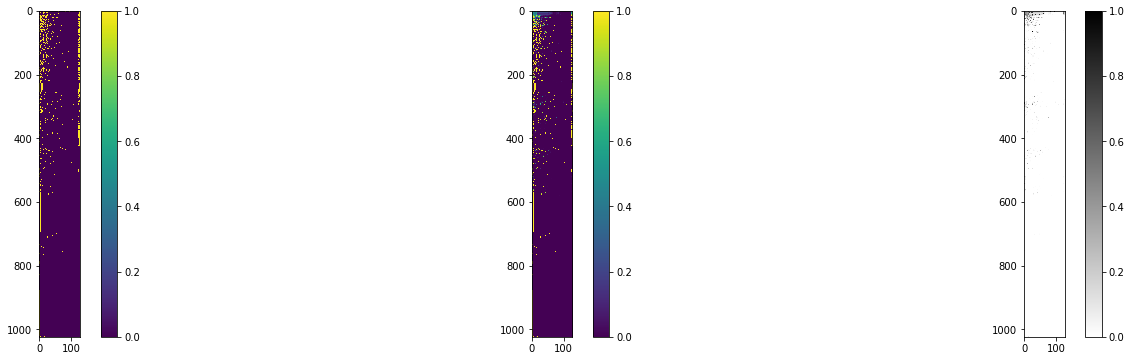

1.124458e-24
0.98880833


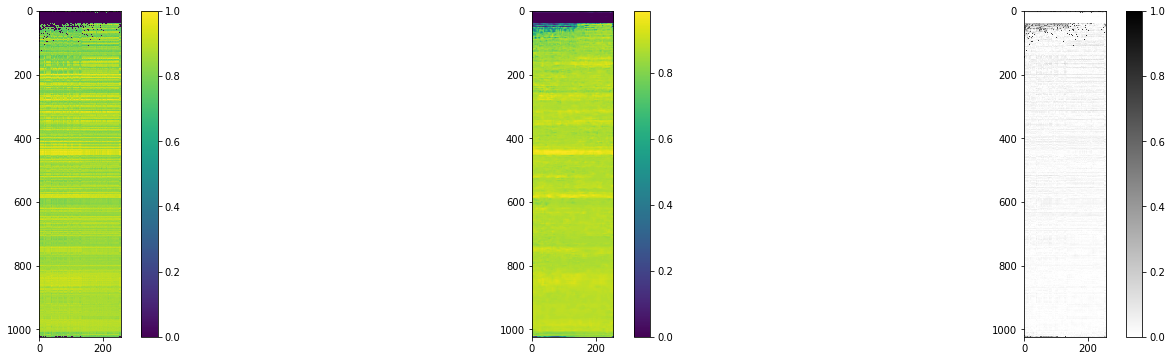

8.5233016e-14
0.56882685


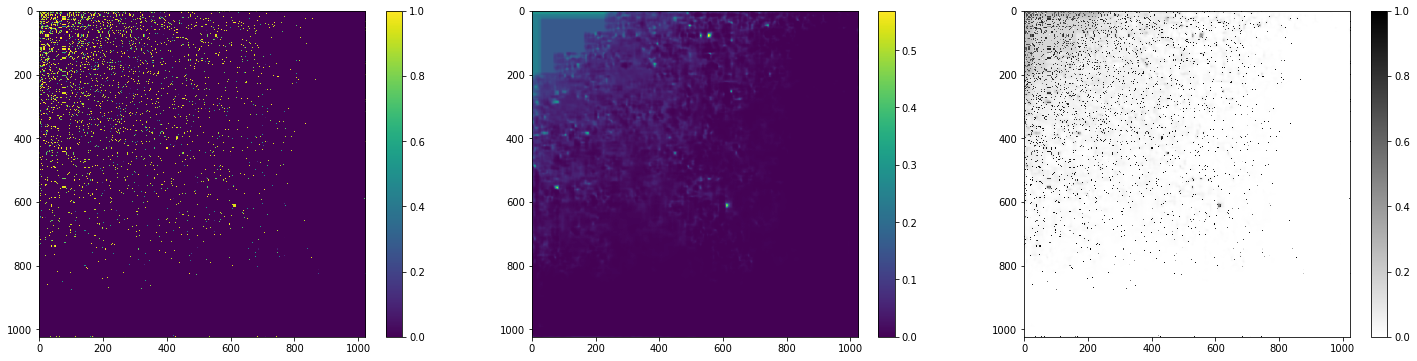

In [13]:
import matplotlib.pyplot as plt
import matplotlib as mpl

path = '/home/lpodgorsek/mag/Final Results/_00/'

# color_pack = 'Blues'
# color_pack = 'jet'
color_pack = 'viridis'
color_pack2 = 'viridis'
# color_pack2 = 'RdBu'
color_pack3 = 'binary'
# color_pack = 'PuOr'
# color_pack = 'rainbow'

for i in range(len(model.org_data)):
    l = model.predict_data[i]
    l = np.delete(l, [x for x in range(1,model.predict_data[i].shape[0])], 0)
    print(l.shape)
    model.predict_data[i] = l;

for i in range(len(model.org_data)):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 6))
    _, row, col, _ = model.org_data[i].shape
    org_data = model.org_data[i].reshape((row, col))
    predict = model.predict_data[i].reshape((row, col))
    
    print(np.min(model.predict_data[i]))
    print(np.max(model.predict_data[i]))
    
    
    ax = axes[0]
    im = ax.imshow(org_data, vmin=0, vmax=1, cmap=plt.cm.get_cmap(color_pack))

    ax = axes[1]
    im2 = ax.imshow(predict, vmin=np.min(predict), vmax=np.max(predict), cmap=plt.cm.get_cmap(color_pack2))

    ax = axes[2]
    im3 = ax.imshow(np.abs(predict - org_data), vmin=0, vmax=1, cmap=plt.cm.get_cmap(color_pack3))
    
    # fig.colorbar(im, ax=axes.ravel().tolist())
#     cax,kw = mpl.colorbar.make_axes([ax for ax in axes.flat])
    cax,kw = mpl.colorbar.make_axes([axes[0]])
    cax2,kw2 = mpl.colorbar.make_axes([axes[1]])
    cax3,kw3 = mpl.colorbar.make_axes([axes[2]])
    
    cba = plt.colorbar(im, cax=cax, **kw)
    cbb = plt.colorbar(im2, cax=cax2, **kw2)
    cbc = plt.colorbar(im3, cax=cax3, **kw3)
    
    plt.savefig(path + 'experiment' + str(numOfExperiment) + '_' + str(i) + '_org_vs_predict.png')

    plt.show()


/home/lpodgorsek/miniconda3/envs/tensorflow/lib/python3.6/site-packages/pandas/plotting/_matplotlib/hist.py:385: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  **kwds


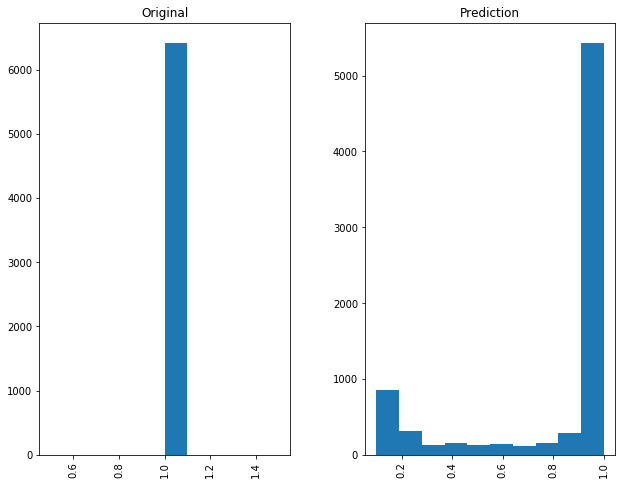

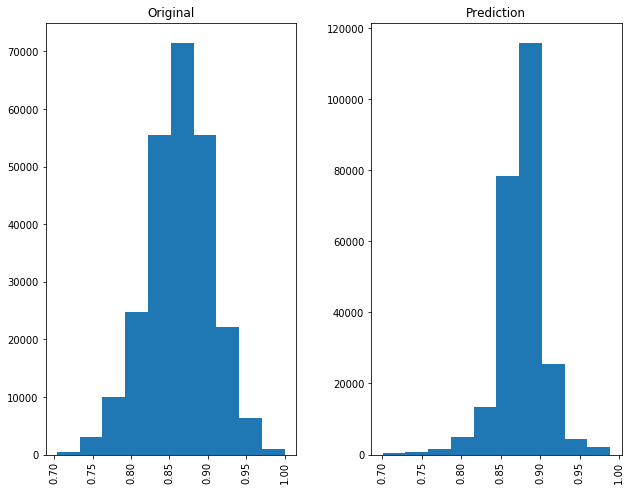

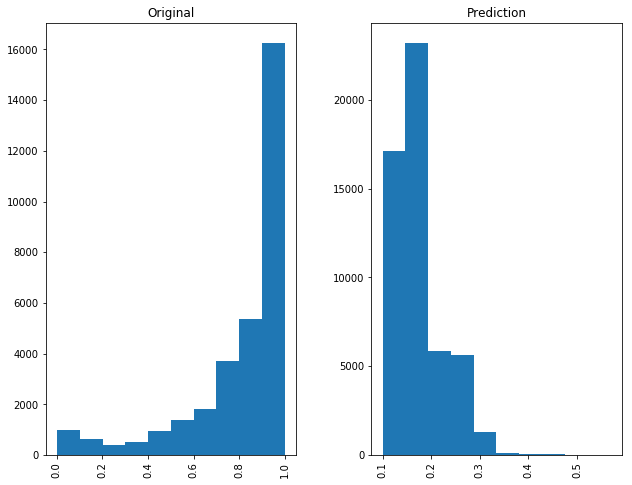

In [14]:
for i in range(len(model.org_data)):
    org_data = model.org_data[i].flatten()
    pred_data = model.predict_data[i].flatten()
    
    data = org_data[org_data > 0]
    indeces = np.zeros(len(org_data[org_data > 0]))
    
    if i == 1:
        data = np.r_[data, pred_data[pred_data > 0.7]]
        indeces = np.r_[indeces, np.ones(len(pred_data[pred_data > 0.7]))]
    else:
        data = np.r_[data, pred_data[pred_data > 0.1]]
        indeces = np.r_[indeces, np.ones(len(pred_data[pred_data > 0.1]))]
    
    new_idx = np.where(indeces == 0, 'Original', indeces)
    new_idx = np.where(indeces == 1, 'Prediction', new_idx)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    df = pd.DataFrame(data)
    df.hist(by=new_idx, bins=10, figsize=(10, 8), ax=ax)
    fig.savefig(path + 'histogram_distribution_' + str(i))
    

/home/lpodgorsek/miniconda3/envs/tensorflow/lib/python3.6/site-packages/pandas/plotting/_matplotlib/__init__.py:62: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


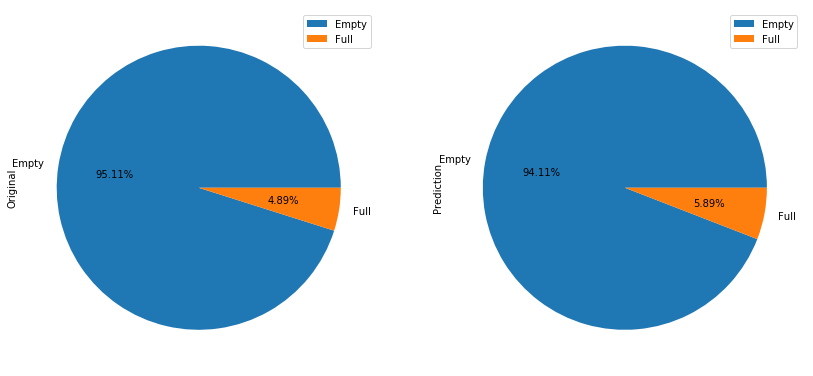

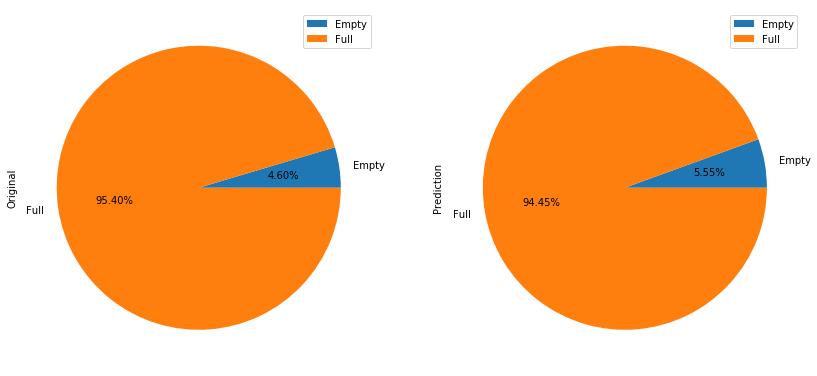

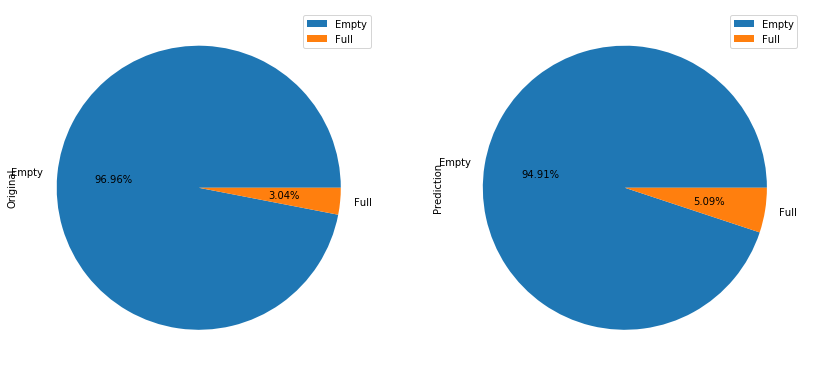

In [15]:
for i in range(len(model.org_data)):
    org_data = model.org_data[i].flatten()
    pred_data = model.predict_data[i].flatten()
    length = len(org_data)
    d = {}
    d['Original'] = []
    d['Original'].append(len(org_data[org_data == 0]) / length)
    d['Original'].append(len(org_data[org_data > 0]) / length)

    if i == 1:
        d['Prediction'] = []
        d['Prediction'].append(len(pred_data[pred_data <= 0.7]) / length)
        d['Prediction'].append(len(pred_data[pred_data > 0.7]) / length)
    else:
        d['Prediction'] = []
        d['Prediction'].append(len(pred_data[pred_data <= 0.1]) / length)
        d['Prediction'].append(len(pred_data[pred_data > 0.1]) / length)

    fig, ax = plt.subplots(figsize=(14,8))
    df = pd.DataFrame(d, index=['Empty', 'Full'])
    df.plot.pie(subplots=True, figsize=(14, 8), autopct='%.2f%%', ax=ax)
    fig.savefig(path + 'pie_density_' + str(i))

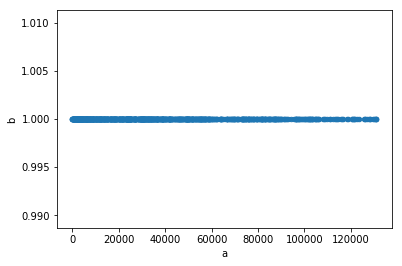

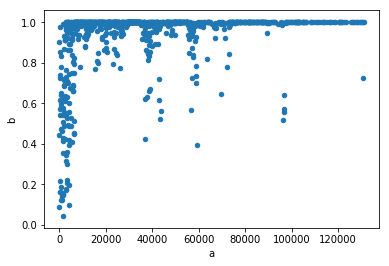

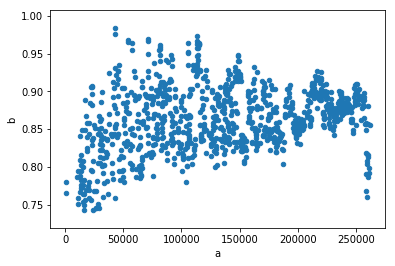

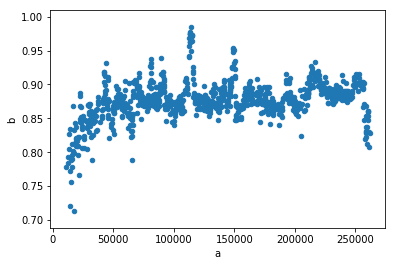

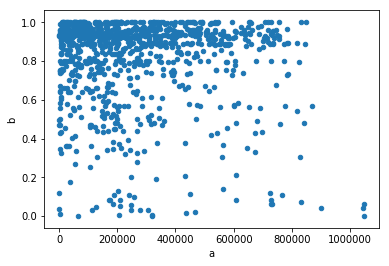

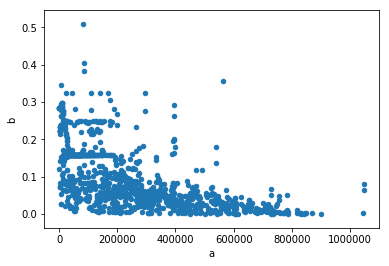

In [16]:
for i in range(len(model.org_data)):
    # df.plot.scatter(x='a', y='b');
    # print(np.random.rand(50, 4))
    org_data = model.saved_cells_for_test[i]
    predict_data = model.predict_saved_cells_for_test[i]
    # print(data)
    new_org_data = []
    new_predict_data = []
    for j in range(len(org_data)):
        if i == 1:
            new_org_data.append([org_data[j][0], org_data[j][1]])
            if predict_data[j][1] > 0.7:
                new_predict_data.append([predict_data[j][0], predict_data[j][1]])
        else:
            new_org_data.append([org_data[j][0], org_data[j][1]])
            new_predict_data.append([predict_data[j][0], predict_data[j][1]])

    df = pd.DataFrame(new_org_data, columns=['a', 'b'])
    df.plot.scatter(x='a', y='b');

    df = pd.DataFrame(new_predict_data, columns=['a', 'b'])
    df.plot.scatter(x='a', y='b');

    new_predict_data

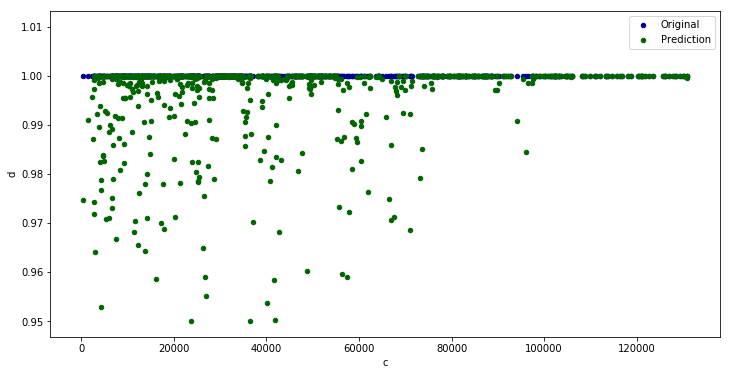

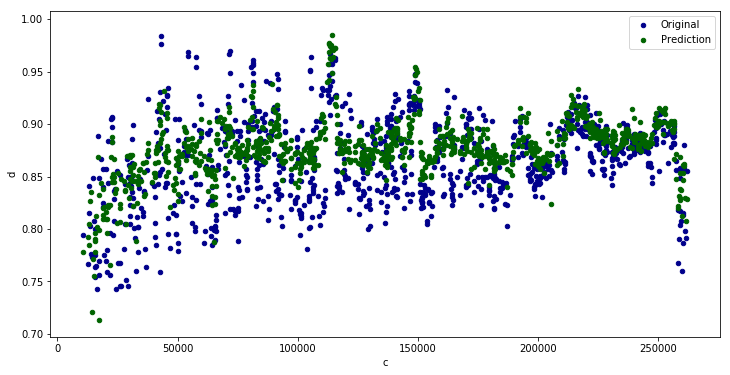

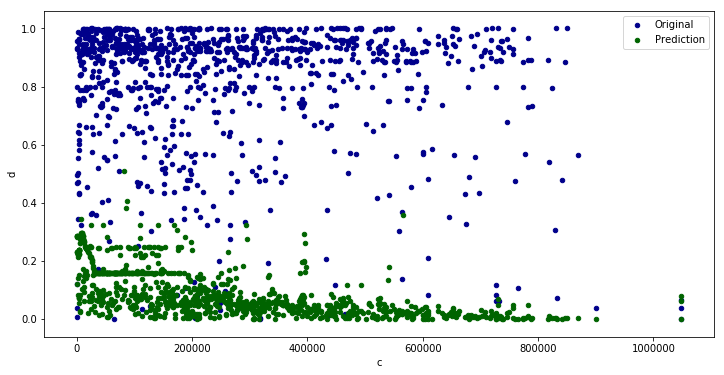

In [17]:
for i in range(len(model.org_data)):
    org_data = model.saved_cells_for_test[i]
    predict_data = model.predict_saved_cells_for_test[i]
    data = []
    for j in range(len(org_data)):
        if i == 0:
            if predict_data[j][1] > 0.95:
                data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])
        elif i == 1:
            if predict_data[j][1] > 0.7:
                data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])
        else:
            data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])

    df = pd.DataFrame(data, columns=['a', 'b', 'c', 'd'])
    
    ax = df.plot.scatter(x='a', y='b', color='DarkBlue', label='Original');
    df.plot.scatter(x='c', y='d', color='DarkGreen', label='Prediction', ax=ax, figsize=(12,6));

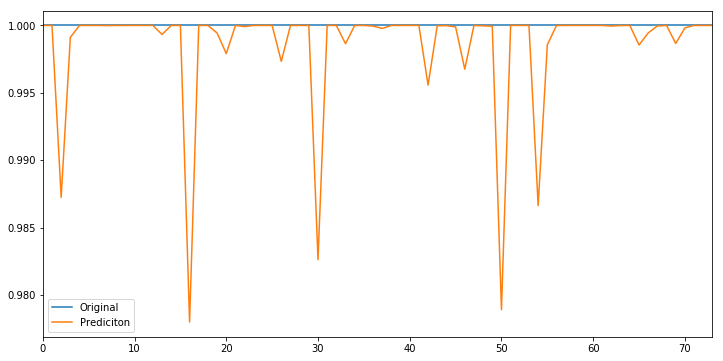

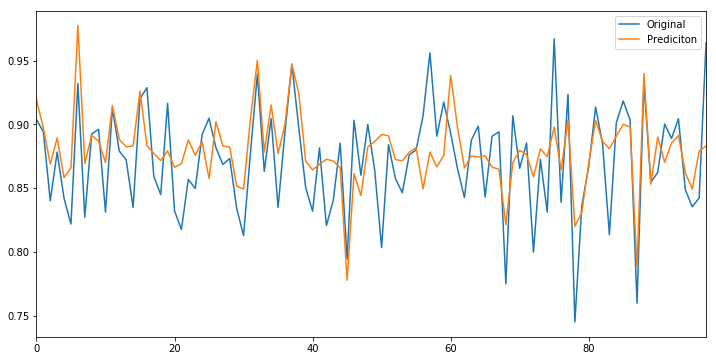

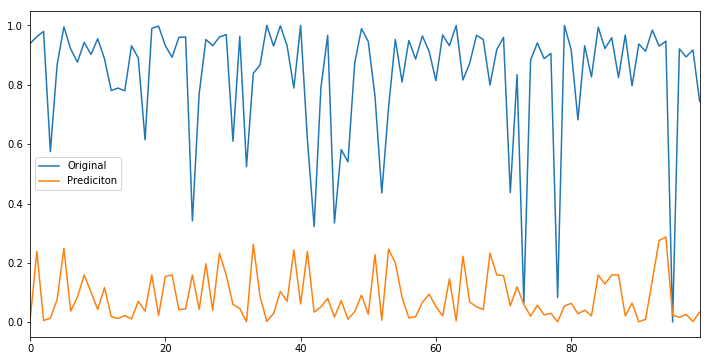

In [18]:
for i in range(len(model.org_data)):
    org_data = model.saved_cells_for_test[i]
    predict_data = model.predict_saved_cells_for_test[i]
    data = []
    for j in range(len(org_data[:100])):
        if i == 0:
            if predict_data[j][1] > 0.95:
                data.append([org_data[j][1], predict_data[j][1]])
        elif i == 1:
            if predict_data[j][1] > 0.7:
                data.append([org_data[j][1], predict_data[j][1]])
        else:
            data.append([org_data[j][1], predict_data[j][1]])

    fig, ax = plt.subplots(figsize=(12,6))
    df = pd.DataFrame(data, columns=['Original', 'Prediciton'])
    df.plot(subplots=False, figsize=(12,6), ax=ax)
    fig.savefig(path + 'graph_org_vs_prediction_' + str(i))